https://realpython.com/working-with-files-in-python/

## Exercise 0: Dataset Preprocessing
**Time Series Classification Datasets.**<BR>
**1. There are multiple datasets in this repository, you need to proceed to the page: https://www.
cs.ucr.edu/~eamonn/time_series_data_2018/ and download the archive.** <BR>

**Approach**<br>
1) All necessary modules are downloaded.<br>
2) All folder directory names are collected using "os.listdir()". During this collection, a folder ""Missing_value_and_variable_length_datasets_adjusted" appeared. This consist of some repeated datasets with missing vlaues and variable lengths adjusted. In the question 1.2, we need to adjust the missing values ourselves. In this regard, I did not take this folder. <br>
3)By iterating through each directory name, the respective train.tsv and test.tsv are read using pd.readcsv and the path of the files. All files are collected into a dictionary "df_list" with key as names of the folders and values as the test and train data. Total datasets collected are 128<br>

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import random
np.random.seed(3116)

In [2]:
df_list={}
l = os.listdir('UCRArchive_2018')
missing_folder="Missing_value_and_variable_length_datasets_adjusted"

In [3]:
for i in l:
    if i!=missing_folder:
        train_df = pd.read_csv("UCRArchive_2018" + "/" + i +"/" + i +"_TRAIN.tsv", header=None, sep="\t")
        test_df = pd.read_csv("UCRArchive_2018" + "/" + i +"/" + i +"_TEST.tsv", header=None, sep="\t")
        df_list[i]=[train_df,test_df]

In [4]:
len(df_list)

128

## 2. Preprocess the datasets in the following way:<br>
**– Merge train and test splits and then re-split into train/validation/test splits according to ratios:
70%/15%/15%. Please take care that you do stratified splits.<br>
– If there are any datasets that do not have equal length samples, then pad the samples with 0s on
the left. (This comes in useful for later distance calculations)<br>
– Standardize the datasets, by removing the mean and scaling to unit-variance ( x−µ)/σ<br>
– Ignore multivariate datasets (if any)<br>**

**Approach**<br>
**Unequal length of samples**
1) I have checked fo the unequal length of samples by checking the shape[1] of the train and test data. <br>
2) There are no files with unequal length of samples. This is because they are already adjusted when I saw a file description of "AllGestureWiimotex", which is outside the missing folder but also repeated in missing folder. I checked the file informaiton outside the folder.It says that, "Each time series is padded with NAN to the longest length of longest timeseries in the dataset" as shown in the figure.<br>
3) I encountered this NAN, while replacing missing values. When I trying to calculate the mean of nearest neighbors  usng nanmean, there are some padded columns that all contained NAN. So I got again NAN at that location. So I replaced such nan with zero. This appraoch can be now similar to paddinng wiht zero but done later as I could not found unequal length of samples by comparing the lengths.<br>

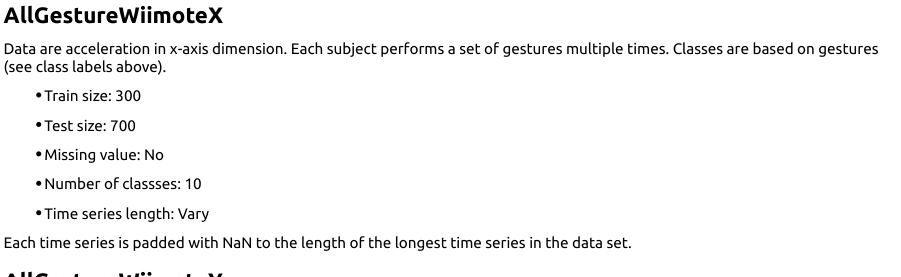

In [5]:
# FInding datasets that do not have equal length samples

df_list_with_unequal_samples=[]
for key, item in df_list.items():
    if df_list[key][0].shape[1] != df_list[key][1].shape[1]:
        df_list_with_unequal_samples.append(key)
print(f'df_list with unequal samples: {df_list_with_unequal_samples}')
print("There are no unequal samples in any data frame")


df_list with unequal samples: []
There are no unequal samples in any data frame


**Merge split stratify**
1) For **merging**, iterating through each value of "list_df" dictioanry, train and test data are accessed and merged using  "pd.concat()". Then resetted the indexes. Merged data frames are collected into df_merged_list <br>
2) For total preprocessing i.e splitting data train,test,validation and standardization and stratified sampling, a main function "split_train_val_test_standardization" is created that takes data frame as an argument.<br>
3) In the function, for **stratified sampling**, a function, "stratified_sampler" is created. The data frame is grouped by class. **70 percent of train,15% of test and validation** of the data is taken from each subgroup of class by indexing.<br>
4) From the stratified train,validation, and test data,  x data and y data are separated. Ydata is the first column of each df. For **standardization**, mean and standard deviation  of x train is evaluated and is used for standardizing the xtrain,xtest & x validation data.<br>
5) Then a bias term is concatenatedat fron of all x datas.<br>
6) So this function, "split_train_val_test_standardization" whenever called, performs all preprocessing steps.<br>
7) A dictionary "final_df_dict" is created to collecte all train,validataion and test data of x data and y data are collected as values with respect to data frame name as key.<br>

In [6]:
#Splitting data train,test,validation and standardization
def split_train_val_test_standardization(df):
    train, val, test=stratified_sampler(df)
    Y_train = train.iloc[:,0].to_numpy()
    Y_val = val.iloc[:,0].to_numpy()
    Y_test = test.iloc[:,0].to_numpy()
    
    mean=train.iloc[:,1:].mean(axis=0)
    stdv=train.iloc[:,1:].std(axis=0)
    
    X_train = ((train.iloc[:,1:]-mean)/stdv).to_numpy()
    X_val = ((val.iloc[:,1:]-mean)/stdv).to_numpy()
    X_test = ((test.iloc[:,1:]-mean)/stdv).to_numpy()
    
    ones_train= np.ones((X_train.shape[0],1))
    ones_val= np.ones((X_val.shape[0],1)) 
    ones_test= np.ones((X_test.shape[0],1)) 
    
    X_train =np.concatenate((ones_train,X_train),axis=1)
    X_val=np.concatenate((ones_val,X_val),axis=1)
    X_test=np.concatenate((ones_test,X_test),axis=1)
    
    return(X_train, X_val, X_test, Y_train, Y_val, Y_test)

def stratified_sampler(df):
    train, test, val = pd.DataFrame(), pd.DataFrame(), pd.DataFrame() #Initializing  dfFrames
    group_by_class = df.groupby(0)
    for class_type, sub_group in group_by_class:
        train = train.append(sub_group.iloc[:int(sub_group.shape[0]*0.7)])
        val = val.append(sub_group.iloc[int(sub_group.shape[0]*0.7):int(sub_group.shape[0]*0.85)]) 
        test = test.append(sub_group.iloc[int(sub_group.shape[0]*0.85):])    
    train = train.sample(n=train.shape[0], random_state=3116)
    val = val.sample(n=val.shape[0], random_state=3116)
    test = test.sample(n=test.shape[0], random_state=3116)
    return(train, val, test)

In [7]:
#merging,stratified sampling and standardizing
final_df_dict = {}
df_merged_list=[]
for key, value in df_list.items():
    df_merged = pd.concat((df_list[key][0], df_list[key][1]),axis=0)
    df_merged.reset_index(inplace=True,drop=True)
    df_merged_list.append(df_merged)
    X_train, X_val, X_test, Y_train, Y_val, Y_test = split_train_val_test_standardization(df_merged)
    final_df_dict[key] = [X_train, X_val, X_test, Y_train, Y_val, Y_test]

## 3. Plot interesting statistics:

### A plot indicating the total the length of samples (across all datasets)

### – Similar to above show number of classes and number of samples.

**Approach**<br>

**total the length of samples**<br>
list of df's are taken and for each df, length of samples are taken using (df.shape[1]-1). -1 is for not considering the target column.<br>
**number of classes**<br>
number of classes in the target column "0" per df is collected using "df[0].nunique()"<br>
**number of samples**<br>
number of samples for each df  are collected using "df.shape[0]".<br>

All the collected values are drawn against the list of df's using barplots

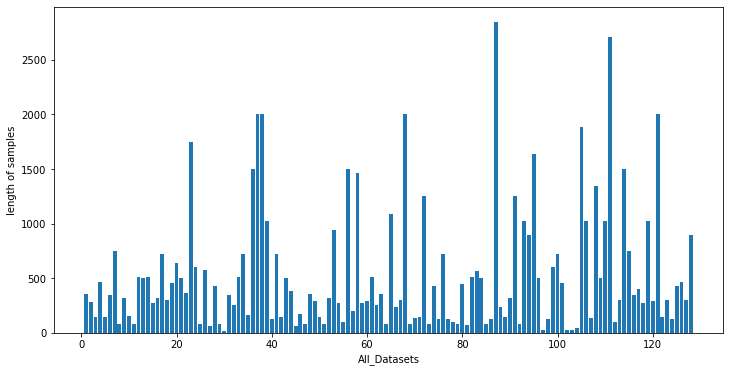

In [43]:
list_dfs=df_merged_list[:]
list_samples=[]
for i in list_dfs:
    list_samples.append((i.shape[1]-1))   #-1 is to remove target from sample count
df_list_count = list(range(1,len(list_dfs)+1))
plt.figure(figsize=(12,6))
plt.bar(df_list_count, list_samples)
plt.ylabel("length of samples")
plt.xlabel("All_Datasets")
plt.show()

– Similar to above show number of classes and number of samples.

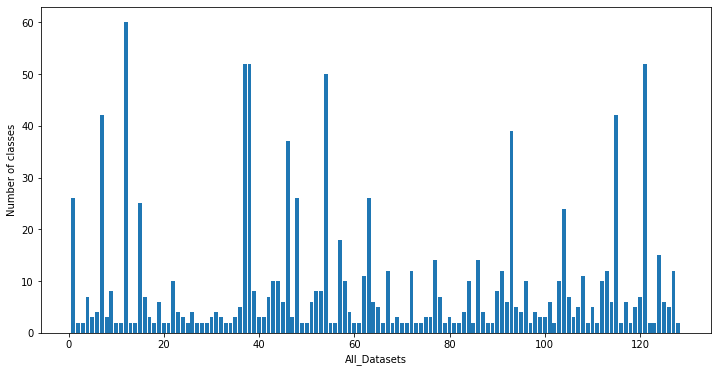

In [44]:
list_classes=[]
for i in list_dfs:
    list_classes.append(i[0].nunique())  
df_list_count = list(range(1,len(list_dfs)+1))
plt.figure(figsize=(12,6))
plt.bar(df_list_count, list_classes)
plt.ylabel("Number of classes")
plt.xlabel("All_Datasets")
plt.show()

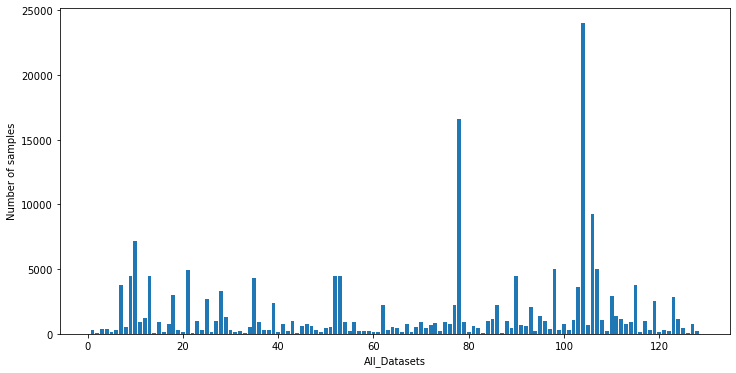

In [45]:
number_samples=[]
for i in list_dfs:
    number_samples.append(i.shape[0])  
    
df_list_count = list(range(1,len(list_dfs)+1))
plt.figure(figsize=(12,6))
plt.bar(df_list_count, number_samples)
plt.ylabel("Number of samples")
plt.xlabel("All_Datasets")
plt.show()

## Exercise 1: Dataset Imputation with KNN

### 1. List the datasets having missing values

**Approach**<br>
1) By iterating through each df of "df_merged_list", the df with missig values or NANs are checked using "df.isnull().values.any()" which returns true if there are NAN's. if true, the df is appended to the required list of "df_with_nan_list"<br>
2) Anda  also corresponding indexes are collected by enumerating "df_merged_list"<br>
3) Using these indexes, the respective names are collected into "df_with_nan" by iterating through "list(final_df_dict.keys())". The respective data frame names with NAN are printed out. There are 15 such data frames<br>

In [46]:
df_number_with_nan = []
df_with_nan_list=[]
for i,df in enumerate(df_merged_list):
    if df.isnull().values.any():  #.isnull().va returns true if df contains NAN
        df_number_with_nan.append(i)
        df_with_nan_list.append(df)
df_names=list(final_df_dict.keys())
df_with_nan=[df_names[x] for x in df_number_with_nan ]
print("Data frames with missing values are :")
print(df_with_nan)
names=df_with_nan

Data frames with missing values are :
['GestureMidAirD2', 'GesturePebbleZ2', 'PickupGestureWiimoteZ', 'AllGestureWiimoteZ', 'ShakeGestureWiimoteZ', 'GestureMidAirD1', 'DodgerLoopGame', 'DodgerLoopWeekend', 'GestureMidAirD3', 'AllGestureWiimoteX', 'AllGestureWiimoteY', 'GesturePebbleZ1', 'MelbournePedestrian', 'PLAID', 'DodgerLoopDay']


### 2. For each dataset with missing values, and for each feature (timestep) of it that has missing values impute the value by calculating the mean of its nearest K neighbors. You need to tune the hyperparameter K via grid search. If in case there are multiple feature values missing, use the same K for all during such tuning.

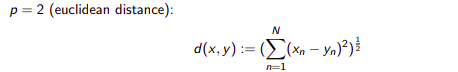

**Approach for imputation**<br>
1) Using the above formula, a fucnction for **euclidean_distance_n()** is created. here nansum is used to ignore nan values while calculating the distance.<br>
2) For **imputation**, 2 functions **"imputating_train"** and **"imputating_with_train"** are created. In "imputating_train",  first x train is imputed considering nan rows as targets and balance rows of x train are treted as neighbors. <br>
3) Then using function ""imputating_with_train",  x validation and x test are imputed by taking respective nan rows as target rows and imputed train data as neighbors. Here validation and train data are considered as future datas.<br> This concept is similar to standardization where mean and variance are taken from train data.<br>
4) Now inside the functions, first all the rows with missing values are collected as "target_nan_rows" using ".loc[ .isna().any(axis=1)]". Then using ".iterrows()", function iterates over each row index and each row of "target_nan_rows".<br>
5) Then for each target row of x_train or valid or test with missing values, distance to the balane rows that is balance rows in training data (in case of imputing x train) or total rows of imputed xtrain (incase of imputation of validation or test) is calculated using function "euclidean_distance_n()". <br>
6) Then for getting nearest neighbor row'ids, the distances "dist" are sorted with respect to thieir indexes in ascending order using np.argsort. Then first "k" neighbors are selected by slicing the list of the indexes.<br>
7) Then mean of these k nearest neigbors is claculated using  "nanmean()" duly neglecting any nan values in neighbors.<br>
8) But while calculating mean values using nanmean, the result "mean_row" still had nan elements at the last. This is because of the padded columns with all NAN's  that were already adjusted in the folder as per the length of samples in website itself. So I replaced the NAN values of the mean row with zeros, using np.nan_to_num()<br>
9) Then for replacing the missing values in the target row with mean values, a data frame "df2" is created to store true and false values for misisng values using .isnull(). Then by checking through each element of this data frame "df2", if an element == True, then the element is replaced with corresponding value of mean _row using ".iloc[nan_row_id,j]=mean_row[j]"<br>
10) I did imputation on df's with nan values by taking k_imp=1 for all datasets for checking.For this, I iterated through the df's with missing values in the list "df_with_nan_list" using enumerate(). Each data frame is preprocessed as above. Later, the obtained train,test,validation data of "x" are converted to dataframes. xtrain is imputed with function ("imputating_train") with k=1, xtest and xvalidation are imputed using function ""imputating_with_train". <br>
11) Later also I have verified on this imputed train,test,validation datas for nan values. I got empty set.<br>


In [47]:
def euclidean_distance_n(x,y):
    return np.sqrt(np.nansum((x-y)**2,axis =-1))  ## nansum is to ignore NAN values

In [48]:
def imputating_train(x_train,k):
    target_nan_rows = x_train.loc[x_train.isna().any(axis=1)]
    for nan_row_id,nan_row in target_nan_rows.iterrows():
        balance_rows = x_train.drop(index=nan_row_id).to_numpy()
        # finding nearest neighbors
        dist = euclidean_distance_n(nan_row.to_numpy(),balance_rows)
        k_nearest_neighbors = list(np.argsort(dist)[:k])
        NN_df = balance_rows[k_nearest_neighbors] 
        #calculating mean of k nearest neighbors
        mean_row=np.nanmean(NN_df,axis = 0)
        mean_row=np.nan_to_num(mean_row)   
        for j in range(nan_row.shape[0]):
            df2=x_train.isnull()
            if df2.iloc[nan_row_id,j]==True:
                x_train.iloc[nan_row_id,j]=mean_row[j]
    return x_train.to_numpy()
def imputating_with_train(x_test,x_train,k):
    target_nan_rows = x_test.loc[x_test.isna().any(axis=1)]
    for nan_row_id,nan_row in target_nan_rows.iterrows():
        balance_rows =x_train
        # finding nearest neighbors
        dist = euclidean_distance_n(nan_row.to_numpy(),balance_rows)
        k_nearest_neighbors = list(np.argsort(dist)[:k])
        NN_df = balance_rows[k_nearest_neighbors] 
        #calculating mean of k nearest neighbors
        mean_row=np.nanmean(NN_df,axis = 0)
        mean_row=np.nan_to_num(mean_row)   
        for j in range(nan_row.shape[0]):
            df2=x_test.isnull()
            if df2.iloc[nan_row_id,j]==True:
                x_test.iloc[nan_row_id,j]=mean_row[j]
    return x_test.to_numpy()

In [71]:
dict_without_nan={}
for i,df in enumerate(df_with_nan_list):
    x_train, x_val, x_test, y_train, y_val, y_test = split_train_val_test_standardization(df)
    x_train, x_val, x_test=pd.DataFrame(x_train),pd.DataFrame(x_val),pd.DataFrame(x_test)
    x_train=imputating_train(x_train,k=1)
    x_val=imputating_with_train(x_val,x_train,k=1)
    x_test=imputating_with_train(x_test,x_train,k=1)
    dict_without_nan[names[i]]=[x_train, x_val, x_test, y_train, y_val, y_test]

<ipython-input-48-5b01b43b52e5>:10: RuntimeWarning: Mean of empty slice
  mean_row=np.nanmean(NN_df,axis = 0)


In [72]:
#checking for nan
df_with_nan_check=[]
for key,values in dict_without_nan.items():
    train_x,val_x,test_x=pd.DataFrame(dict_without_nan[key][0]),pd.DataFrame(dict_without_nan[key][1]),pd.DataFrame(dict_without_nan[key][2])
    if train_x.isnull().values.any():
        df_with_nan_check.append(key)
    elif val_x.isnull().values.any():
        df_with_nan_check.append(key)
    elif test_x.isnull().values.any():
        df_with_nan_check.append(key)
print(f" Dataframes list with nan after imputation : {df_with_nan_check}")

 Dataframes list with nan after imputation : []


### 3. Next, train a K-Nearest Neighbour classifier (pseudo-code given in slides) with majority voting and euclidean distance to maximize accuracy on the validation split by tuning K via grid search.
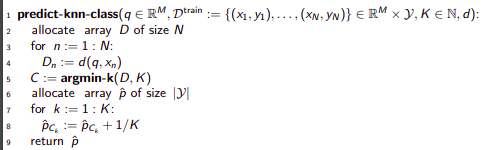

**Approach for classification**<br>
1) For classifying using K nearest neighbors, a function named "predict_knn_class" is created as per the above algorithm. This fucntion takes "x_train, y_train, x_val, y_val, K" as inputs. An array D of size N, to collect ecuclidena distances against each neighbor of x train to the query row, is created. N is number of samples in train data.<br>
2) Two loops are created. The outer loop iterates over each query point. The inner loop iterates over number of smaples in train data i.e N.<br>
3) For each query point, euclidean distance between each row of train data are calculated and updated in "D[n]". Defined euclidean distance function as per the formula.<br>
4) Then for getting indexes of k nearest neighbors, a funtion called "argmin_k" is created. In this, given set of distances "D" are sorted in ascending order and indices are taken using np.argsort and slicing<br>
5) For finding most repeated class as label of the query i.e as per majority voting, a function called " prediction" is created. This uses np.bincounts that takes non negative values and gives the count of occurence of each class. Then the respective index with maximum counts is taken using np.argmax. which will be the required label of the query. This label is added to the "prediction" array at index "i"<br>
6) At the end of outer loop, all query points will be assigned their labels.Based on these predictions accuracy is calculated.<br>
7) For calculating accuracy, a function "calc_accuracy" is created. This function compare the obtained labels with actual labels. if a match occurs, output is collected as 1 in a list. Then all ones are added and the sum is divided by the len(y_test). This gives accuracy.<br>
8) I took the datasets that are imputed with k_imp=1,i.e "dict_without_nan", by iterating through each dataset, for K =[1,3,5,7,9], validation accuracy is calculated using "predict_knn_class" function. Then the repective k for which validation accuracy is maximum is taken as the optimal k for that data frame. Results with df's and respective optimal k for classifiication are printed out.<br>

Ref:https://stackoverflow.com/questions/6252280/find-the-most-frequent-number-in-a-numpy-array


In [8]:
def euclidean_distance(q, x_n):
        return np.sqrt(np.sum((q - x_n)**2))
    
def argmin_k(D, K):
    C= np.argsort(D)[:K]
    return(C)

def predict(classes):
    classes = np.array(classes)
    counts = np.bincount(classes.astype(int))
    label=np.argmax(counts)
    return label

def calc_accuracy(y_test, y_hat):
    l=[1 for i in range(len(y_hat)) if y_test[i] == y_hat[i]]
    accuracy = sum(l) / len(y_test)
    return(accuracy)

In [9]:
def predict_knn_class(x_train, y_train, x_val, y_val, K):
    N = x_train.shape[0]   # Number of samples
    D = np.zeros(shape=(N))  # Allocation of array D of size N
    predictions = np.zeros((y_val.shape[0],1))
    # Predict class by iterating through each instance of x_val
    for i in range(x_val.shape[0]):
        for n in range(N):
            q=x_val[i]
            D[n] = euclidean_distance(q, x_train[n])
            
        C = argmin_k(D, K)  # Get the indexes of the k nearest neighbors
        
        # Get the respecttive classes of x_train using the indexes 
        nearest_neighbor_classes = [y_train[int(index)] for index in C ]  
        # Predict the label of the to be preicted data point
        predictions[i] = predict(nearest_neighbor_classes)

    val_accuracy = calc_accuracy(y_val, predictions)
    
    return(val_accuracy)

In [79]:
# Create grid of K
K =[1,3,5,7,9]
k_best_df = {}
for i in names:
    acc_global=0
    # Perform hyperparameter tuning using the train and validation split
    for k in K:
        xtrain,ytrain,xval,yval=dict_without_nan[i][0],dict_without_nan[i][3],dict_without_nan[i][1],dict_without_nan[i][4]
        val_acc = predict_knn_class(xtrain,ytrain,xval,yval,k)
        if val_acc>acc_global:
            optimal_k=k
            acc_global=val_acc     
        else:
            continue
    k_best_df[i]=optimal_k

In [80]:
k_best_df

{'GestureMidAirD2': 1,
 'GesturePebbleZ2': 3,
 'PickupGestureWiimoteZ': 3,
 'AllGestureWiimoteZ': 3,
 'ShakeGestureWiimoteZ': 1,
 'GestureMidAirD1': 1,
 'DodgerLoopGame': 9,
 'DodgerLoopWeekend': 1,
 'GestureMidAirD3': 1,
 'AllGestureWiimoteX': 1,
 'AllGestureWiimoteY': 1,
 'GesturePebbleZ1': 1,
 'MelbournePedestrian': 5,
 'PLAID': 1,
 'DodgerLoopDay': 7}

### 4) Report the final test accuracy for each dataset by using the optimal K found for imputation and the optimal K found for classification. Please jointly tune the two Ks.

**Approach**<br>
1) For finetuning with two Ks , k_imp & k = [1,3,5,7,9], across df's with missing values, three loops are created. The outer loop iterates over data frames. Second loop iterates over each k for imputation. The inner loop iterates over each k for classification.<br>
2) For each "k_imp", and for each k for classification, data frame is preprocessed using "split_train_val_test_standardization" function. .Then missing values of x_train,x_val and x_test are imputed with respect to k_imp as per the procedure already mentioned above.<br>
3) Then for each k, val_accuracy is calculate using function "predict_knn_class". Then this validation accuracy is compared with global accuracy. if validation accuracy is greater than global accuracy,global accuracy , optimal k and optimal k_impute are updated.<br> 
4) At the end of 2nd loop, optimal k for classification and optimaal k_impfor imputation are obtained for each df. With these optimal values of k_imp  and k for classification, test accuracy is calculated first by making imputation and then predicting test labels using "predict_knn_class". The results are printed out.<br>

In [82]:
k_imp = [1,3,5,7,9]
k= [1,3,5,7,9]

df_best_k_best_k_imput_val_accuracy={}
for p,df in enumerate(df_with_nan_list):
    acc_global=0
    #imputation
    for i_imp in k_imp:
        x_train, x_val, x_test, y_train, y_val, y_test = split_train_val_test_standardization(df)
        x_train, x_val=pd.DataFrame(x_train),pd.DataFrame(x_val)
        x_train=imputating_train(x_train,k=i_imp)
        x_val=imputating_with_train(x_val,x_train,k=i_imp)
        #classification
        for j_k in k:
            val_acc = predict_knn_class(x_train,y_train,x_val,y_val,j_k)

            if val_acc>acc_global:
                optimal_k=j_k
                optimal_k_imp=i_imp
                acc_global=val_acc     
            else:
                continue
    df_best_k_best_k_imput_val_accuracy[names[p]]=[optimal_k, optimal_k_imp]
    
    print(f"for df {names[p]},  otimal k for classification ={optimal_k}  and optimal k impute={optimal_k_imp}")

<ipython-input-48-5b01b43b52e5>:10: RuntimeWarning: Mean of empty slice
  mean_row=np.nanmean(NN_df,axis = 0)


for df GestureMidAirD2,  otimal k for classification =1  and optimal k impute=1
for df GesturePebbleZ2,  otimal k for classification =3  and optimal k impute=5
for df PickupGestureWiimoteZ,  otimal k for classification =3  and optimal k impute=9
for df AllGestureWiimoteZ,  otimal k for classification =1  and optimal k impute=7
for df ShakeGestureWiimoteZ,  otimal k for classification =1  and optimal k impute=1
for df GestureMidAirD1,  otimal k for classification =7  and optimal k impute=3
for df DodgerLoopGame,  otimal k for classification =9  and optimal k impute=1
for df DodgerLoopWeekend,  otimal k for classification =1  and optimal k impute=1
for df GestureMidAirD3,  otimal k for classification =1  and optimal k impute=3
for df AllGestureWiimoteX,  otimal k for classification =1  and optimal k impute=9
for df AllGestureWiimoteY,  otimal k for classification =1  and optimal k impute=1
for df GesturePebbleZ1,  otimal k for classification =1  and optimal k impute=1
for df MelbournePed

In [83]:
df_best_k_best_k_imput_test_accuracy={}
for p,df in enumerate(df_with_nan_list):
    best_k_imp=df_best_k_best_k_imput_val_accuracy[names[p]][1]
    best_k=df_best_k_best_k_imput_val_accuracy[names[p]][0]
    #imputation
   
    x_train, x_val, x_test, y_train, y_val, y_test = split_train_val_test_standardization(df)
    x_train,x_test=pd.DataFrame(x_train),pd.DataFrame(x_test)
    x_train=imputating_train(x_train,k=best_k_imp)
    x_test=imputating_with_train(x_test,x_train,k=best_k_imp)
    #classification

    test_acc= predict_knn_class(x_train,y_train,x_test,y_test,best_k)
           
    df_best_k_best_k_imput_test_accuracy[names[p]]=[best_k, best_k_imp, test_acc]
    
    print(f"for df {names[p]}, the best test acc is {test_acc} at optimal k impute={best_k_imp} at otimal k={best_k} ")

<ipython-input-48-5b01b43b52e5>:10: RuntimeWarning: Mean of empty slice
  mean_row=np.nanmean(NN_df,axis = 0)


for df GestureMidAirD2, the best test acc is 0.36538461538461536 at optimal k impute=1 at otimal k=1 
for df GesturePebbleZ2, the best test acc is 0.7291666666666666 at optimal k impute=5 at otimal k=3 
for df PickupGestureWiimoteZ, the best test acc is 0.35 at optimal k impute=9 at otimal k=3 
for df AllGestureWiimoteZ, the best test acc is 0.5066666666666667 at optimal k impute=7 at otimal k=1 
for df ShakeGestureWiimoteZ, the best test acc is 0.8 at optimal k impute=1 at otimal k=1 
for df GestureMidAirD1, the best test acc is 0.34615384615384615 at optimal k impute=3 at otimal k=7 
for df DodgerLoopGame, the best test acc is 0.8 at optimal k impute=1 at otimal k=9 
for df DodgerLoopWeekend, the best test acc is 1.0 at optimal k impute=1 at otimal k=1 
for df GestureMidAirD3, the best test acc is 0.19230769230769232 at optimal k impute=3 at otimal k=1 
for df AllGestureWiimoteX, the best test acc is 0.6 at optimal k impute=9 at otimal k=1 
for df AllGestureWiimoteY, the best test ac

##  Exercise 2: Time Series Classification with Various Distance Measures

### 1. For each distance measure on the page: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html and for each dataset in the repository, use the validation samples to tune the parameter K and selecting one distance measure. With this optimal distance and value of K, compute the test accuracy

**Approach for tuning distance metric and k**<br>
1) All distance metrics are collected except Mahalanobis. "Mahalanobis" involved calculation of inverse of covariance matrix. This takes too much time to calulate. To find distances using these metrics, pdist is imported from scipy.spatial.dsitance. This pdist function takes an array (X) and distance metric as arguments. <br>
2) For classification, a function "predict_knn_class_scipy" is created. This is similar to the above classification function. The only difference is, it itakes distance metric as one more argument. And this distance metric and pdist function is used to calculate the distance between rows. Based on these distances, labels are predicted using majority voting as per the procedure already mentioned.<br>
3) For chosing optimak k and optimal distance for each dataframe, 3 for loops are created. The first loop iterates over each dataframe. Second loop iterates over each distance metric. Third loop iterates over set of K's i.e [1,3,5,7,9].<br>
4) For each distance metric and for each k nearest neighbors, validation accuracy is calculated using "predict_knn_class_scipy" function. Then the repective k and distance metric for which validation accuracy is maximum by comparing with global accuracy, is taken as the optimal k and optimal distance metric for that data frame.<br>
5) From this optimla values, test accuracy is calculated using same classification function. Respective, test accuracy , optimal k and optimal distance metric are collected into a dictionary "df_best_k_and_metric_and_test_accuracy" with respect to df.Results of df's and respective test accuracy, optimal k  and optimal distance metric for classifiication are printed out.<br>
6) While selecting data frames, I took 10 datasets from 1 to 11. The data frame at index "0" is a df "'GestureMidAirD2'" with missing values. This df is avoided to avoid imputation claculation. Then the df at index 9 is "Wafer". This contained, negative classes as "-1". Due to this I got the error as "list' argument must have no negative elements". Due to limited time, I also skipped this to avoid replacing the negative classes with "zeros".<br>
7) In total 10 data frames are taken for tuning parameters.<br>

In [87]:
all_metrics = ['euclidean', 'minkowski', 'cityblock', 'seuclidean', 'sqeuclidean', 'cosine', 'correlation', 'hamming', 'jaccard', 'jensenshannon','chebyshev', 'canberra', 'braycurtis', 'yule', 'matching', 'dice', 'kulsinski', 'rogerstanimoto', 'russellrao', 'sokalmichener', 'sokalsneath']

In [88]:
from scipy.spatial.distance import pdist

In [94]:
def predict_knn_class_scipy(x_train, y_train, x_val, y_val, K,distance_metric):
    N = x_train.shape[0]   # Number of samples
    D = np.zeros(shape=(N))  # Allocation of array D of size N
    predictions = np.zeros((y_val.shape[0],1))
    # Predict class by iterating through each instance of x_val
    for i in range(x_val.shape[0]):
        for n in range(N):
            q=x_val[i]
            D[n] = pdist(np.stack((q,x_train[n]),axis=0),distance_metric)
            
        C = argmin_k(D, K)  # Get the indexes of the k nearest neighbors
        
        # Get the respecttive classes of x_train using the indexes 
        nearest_neighbor_classes = [y_train[int(index)] for index in C ]  
        # Predict the label of the to be preicted data point
        predictions[i] = predict(nearest_neighbor_classes)

    val_accuracy = calc_accuracy(y_val, predictions)
    
    return(val_accuracy)

In [95]:
df_number_with_nan

[0, 18, 21, 42, 43, 47, 48, 59, 62, 83, 95, 100, 102, 107, 119]

In [96]:
list(final_df_dict.keys())[0]

'GestureMidAirD2'

In [98]:
# Create grid of K
K = [1,3,5,7,9]
df_best_k_and_metric_and_test_accuracy = {}
list_dfs=list(final_df_dict.keys())[1:12]
for i in list_dfs:
    if i!='Wafer':
        xtrain,ytrain,xval,yval=final_df_dict[i][0],final_df_dict[i][3],final_df_dict[i][1],final_df_dict[i][4]
        xtest,ytest=final_df_dict[i][2],final_df_dict[i][5]
        val_acc_global = 0
        for distance_metric in all_metrics:
            for k in K:
                val_acc = predict_knn_class_scipy(xtrain,ytrain,xval,yval,k,distance_metric)
                if val_acc > val_acc_global:
                    optimal_metric=distance_metric
                    optimal_k=k
                    val_acc_global=val_acc       
                else:
                    continue
    if i!='Wafer':
        test_acc = predict_knn_class_scipy(xtrain,ytrain,xtest,ytest,optimal_k,optimal_metric)

        df_best_k_and_metric_and_test_accuracy[i]=[optimal_metric,optimal_k,test_acc]
        print(f"for df {i}, the best test acc is {test_acc} at optimal k={optimal_k} at optimal metric {optimal_metric}")

for df Coffee, the best test acc is 1.0 at optimal k=1 at optimal metric euclidean
for df PowerCons, the best test acc is 1.0 at optimal k=1 at optimal metric euclidean
for df Fish, the best test acc is 0.8928571428571429 at optimal k=1 at optimal metric euclidean
for df UMD, the best test acc is 0.5185185185185185 at optimal k=1 at optimal metric canberra
for df DiatomSizeReduction, the best test acc is 1.0 at optimal k=1 at optimal metric euclidean
for df NonInvasiveFetalECGThorax2, the best test acc is 0.8668941979522184 at optimal k=1 at optimal metric braycurtis
for df MiddlePhalanxOutlineAgeGroup, the best test acc is 0.5119047619047619 at optimal k=5 at optimal metric euclidean
for df UWaveGestureLibraryY, the best test acc is 0.7083333333333334 at optimal k=9 at optimal metric cosine
for df MiddlePhalanxOutlineCorrect, the best test acc is 0.8074074074074075 at optimal k=7 at optimal metric braycurtis
for df ShapesAll, the best test acc is 0.8 at optimal k=1 at optimal metric b

### 2. Aggregate the results across all datasets, and rank all distance metrics according to the test accuracy.

**Approach for aggregation and ranking the metric**
1) all optimal distance metric and optimal k are collected into a list from the respective dictioanry.<br>
2) These list are takena as column values in a new data frame "df". Then to aggregate test accuracy based on distance metric, all test accuracies are grouped by "metric" and mean is applied on the group. The aggregated results of test accuracy against distance metric are printed out.<br>
3) For ranking, the aggregated data frame is sorted based on the test_accuracy  in ascending order and indexes are reset to get the respective ranks. Euclidean distance got the highest rank. The results are printed out.

In [105]:
best_metric=[x[0] for x in list(df_best_k_and_metric_and_test_accuracy.values())]
best_test_accuracy=[x[2] for x in list(df_best_k_and_metric_and_test_accuracy.values())]
df = pd.DataFrame({'metric':best_metric,'test_accuracy':best_test_accuracy})
df_by_metric=df.groupby('metric',as_index=False)['test_accuracy'].mean()

print("All aggregated test accuracies against each distance metric:")
print("----------------------------------------")
print(df_by_metric)

#ranking the metric
ranked_metric=df_by_metric.sort_values(by=['test_accuracy']).reset_index(drop=True)
print("ranked distance metrics according to the test accuracy.")
print("----------------------------------------")
print(ranked_metric)

#Finding the ultimate best metric with highest average test accuracy
Final_best_metric=ranked_metric["metric"].iloc[-1]
print("----------------------------------------")
print(f"Final_best_metric with maximum test accuracy across datasets taken is:{Final_best_metric}")

All aggregated test accuracies against each distance metric:
----------------------------------------
       metric  test_accuracy
0  braycurtis       0.824767
1    canberra       0.518519
2      cosine       0.708333
3   euclidean       0.880952
ranked distance metrics according to the test accuracy.
----------------------------------------
       metric  test_accuracy
0    canberra       0.518519
1      cosine       0.708333
2  braycurtis       0.824767
3   euclidean       0.880952
----------------------------------------
Final_best_metric with maximum test accuracy across datasets taken is:euclidean


## Exercise 3: Accelerating K-Nearest Neighbour Classifier
### 1. Partial Distances/Lower Bounding
### 2. Locality Sensitive Hashing 
### Please use the Euclidean distance and the dataset with the largest number of samples for this exercise. Justify the choice of associated hyperparameters of the above two strategies accordingly

**Approach for finding the largest data frame**
1) For findig the df with largest number of samples, I took list of number of samples from the shape index "0" of each data frame. Then this list is argsorted in ascendig order. The last element of the result will be required index. Data frame coorresponding to the obtained index and shapes are printed out. The obtained df is "Crop" with size (24000,47) <br>

In [12]:
# finiding data frame with largest number of samples
list_number_of_samples=np.array([df_merged_list[i].shape[0] for i in range(len(df_merged_list))])
sorted_indexes=np.argsort(list_number_of_samples)
total_list_dfs=list(final_df_dict.keys())
largest_df_in_number_of_samples=total_list_dfs[sorted_indexes[-1]]

id_=sorted_indexes[-1]
print("Df with largest number off samples:" ,largest_df_in_number_of_samples)
print("shape is:", df_merged_list[id_].shape)

Df with largest number off samples: Crop
shape is: (24000, 47)


### 1. Partial Distances/Lower Bounding

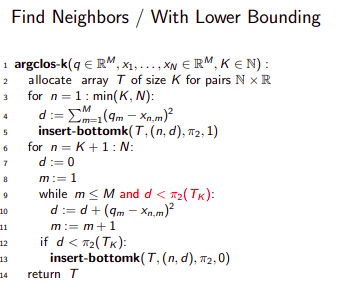

**Approach for Lower Bounding**
1) This method is based on calculating the partial distances  and early stopping if the distance calculated exceeds the k^th minimum distances.<br>
2) Following the above alogorithm, a function called **"argclos_k"** is created. This function takes query row, x_train and k as argument.<br>
3) varialbes "M" and "N" are assigned with length of samples and number of samples respectively. Then a distance array "D" of size "K" is created. Then by iterating through first "K" rows of x_train, the distance array "D" is filled with euclidean distances (withot square root), between query row and "K" rows of x_train data. Hence this array consist of k diastances. <br>
4) Then the array "D" is sorted in ascending order and respective argsorted indexes are collected in "C". To iterate over balance rows of x_train, a for loop is created. Inside the loop, following the alogorithm, d,m are set to zero.
5) A while loop is created which checks for the conditions (m<M) i.e m should be length of samples. The other condition is d<D[K-1] i.e the calculated euclidean edistance d with m features should be less than the Kth minimum distance of "D". Inside this loop, distance "d" is calculated and cumulated with respect to each feature m. This loop continues untill any condition does not satisy. This allows us not going for calculating the distances between all features unnecessarily. <br>
6) After this loop, the obtained distance "d" is compared with Kth minimum distance of D. if d<D[K-1], the set of k minimum distances "D" is updated as per the insert bottom concept.<br>
7) By iterating through each element of the "D", the distances are compared with the calculated distance "d". If d is less than the distance in "D", then respective distance "d" and row index  "n" are inserted in "D" and "C" at index i using ".insert() respectively. Then loop breaks <br>
8) In each iteration of outer for loop, the arrays of Distances "D" and the array of indexes "C" gets updated with all inserted values.<br>
9) Finally the updated list of indexes of "K" nearest neighbors i.e "C" is taken as function return value.


In [101]:
def euclidean_distance_n(q, x):
        return np.sum((q - x)**2)    

In [102]:
def argclos_k(q,x_train,K):
    N=x_train.shape[0]
    M=x_train.shape[1]
    D = np.zeros(shape=(K))  # Allocation of array D of size K
    for n in range(min(K,N)):
        D[n] = euclidean_distance_n(q, x_train[n])
    C = list(np.argsort(D))
    D = list(sorted(D))
    for n in range(K,N):
        d=0
        m=0
        while(m<M) & (d<D[K-1]):
            d=d+euclidean_distance_n(q[m], x_train[n,m])
            m+=1
        if d<D[K-1]:
            for i in range(k):
                if d<D[i]:
                    D.insert(i, d)     # updating the minimum distance in the list of K nearest distances.
                    C.insert(i,n)     # updating neighbor index at corresponding location where calculate distace is less than the distance in D[i]                  
                    break 
    return C[:K]

**Approach for classification**<br>
1) For classifying using kower bounding, a function named "predict_knn_class_lower" is created as per the above algorithm. This fucntion takes "x_train, y_train, x_val, y_val, K" as inputs. 
2) A for loop iscreated. The loop iterates over each query point.This query point and x train and k value are given to "argclos_k" function. This returns the indexes of knearest neighbors. Based on this indexes the label of the query point is predicted. By the end of the loop, labels of all query points are predicted.
3) Then accuracy is calculated using this predictions and the same is returned.

**Chosing hyperparameter "K"**<br>
1) Here best k is chosen using search method of best "k", as already done in KNN Classification method in 1.3 section.<BR>
2) On the data frame with largest number of samples i.e "Crop", search for best k i.e which yields best validation accuracy is done using **lower bounding method**. With obtained best k, test accuracy is evaluated. To check, the test accuracy with **normal method of KNN classification** is also calculated with best_k. The test accuracies of normal method and lower bounding method should be same. Only the lower bounding method should be fast.<br>
3) I compared the test accuracies in both methods They are equal.

In [120]:
def predict_knn_class_lower(x_train, y_train, x_val, y_val, K):
    predictions = np.zeros((y_val.shape[0],1))
    # Predict class by iterating through each instance of x_val
    for i in range(x_val.shape[0]):
            q=x_val[i]
            
            C=argclos_k(q,x_train,K)  # Get the indexes of the k nearest neighbors

            # Get the respecttive classes of x_train using the indexes 
            nearest_neighbor_classes = [y_train[int(index)] for index in C ]  
            # Predict the label of the to be preicted data point
            predictions[i] = predict(nearest_neighbor_classes)

    val_accuracy = calc_accuracy(y_val, predictions)
    return(val_accuracy)

#### Finding best K and finding test accuracy with best k using lower bound method of KNN Classification

In [121]:
# Create grid of K
K = [1,2,3]
i=largest_df_in_number_of_samples
xtrain,ytrain,xval,yval=final_df_dict[i][0],final_df_dict[i][3],final_df_dict[i][1],final_df_dict[i][4]
xtest,ytest=final_df_dict[i][2],final_df_dict[i][5]
val_acc_global = 0
# Perform hyperparameter tuning using the train and validation split
for k in K:
    print(k)
    val_acc = predict_knn_class_lower(xtrain,ytrain,xval,yval,k)
    if val_acc > val_acc_global:
        optimal_k=k
        val_acc_global=val_acc 
    else:
        continue
print("opt k is", optimal_k)
        
test_acc = predict_knn_class_lower(xtrain,ytrain,xtest,ytest,optimal_k)
print(f" Test accuracy usinng lower bound method is {test_acc}")

1
2
3
opt k is 1
 Test accuracy usinng lower bound method is 0.7669444444444444


#### Finding test accuracy with best k using normal method of KNN Classification

In [122]:
test_acc_normal=predict_knn_class(xtrain,ytrain,xtest,ytest,optimal_k)
print(f" Test accuracy usinng normal method is {test_acc_normal}")

 Test accuracy usinng normal method is 0.7669444444444444


### 2. Locality Sensitive Hashing

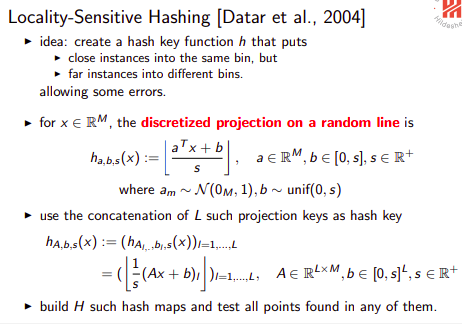

Ref:https://www.youtube.com/watch?v=NJaJrVF__B4


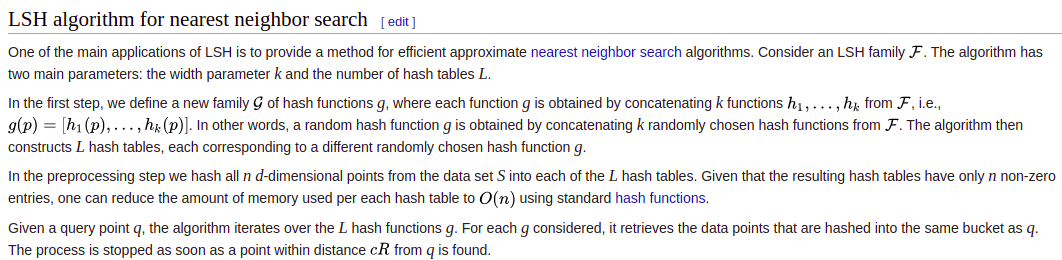
Ref:https://en.wikipedia.org/wiki/Locality-sensitive_hashing

**Algorithm followed is**<br>
for each query point, 50 tables are created. In each table,
1) hashkey is calculated for each training point using the randomly chosen functions as per the given algorithm.<br>
2) All training points with same hash key are transfered into bins.<br>
3) Then hash key for the query point is computed with the same random functions.<br>
4) Then this query point is transfered to the bin with respect to the hashkey.<br>
5) All the training points in matched bin is taken as neighbors to the query point.<br>
6) From these neighbors, euclidean distance between the query point to the  neighbors is calculated.<br>
7) Then all these distances are compared with the prdefined limit of cR (where R is a threshold with R>0 and c is an approximation factor with c>1). If the distance is less than the cR, then corresponding class of neighbor is collected and the loop stops as soon as the condition satisfies.<br>
8) Such classes  are collected from all 100 tables. Then final label is predicted for the query point using these classes.<br>

**Approach in detail**
1) Following the above algorithm, wikipedia and video on locaity sensitive hashing, the approach will be as follows.<br>
2) First a function named "H_Map" , which can also be seen as table, is created. This takes query point "q", no of functions as "L", number of features "M",x_train,y_train and i (for random seed) as arguments. The  variables "A","b" & "s" are randomly defined as per the algorithm.<br>
3) Inside this function, bin_dictionaries are created to accomodate train instances and lables with respect to their hash key.  <br>
4) To calculate the hash key,a function named "hash_key" is created. This takes each x_train row and (A,b,s) as arguments. Then family of random "L" number of hash functions "h" , is created as per the formula of h_(a,b,s)(x) given in the algorithm. <br>
5) Then the each element of "h" is compared with zero. if h[i] is > zero, string of "1" is added to the list. Else, string of "0" is added. This list of strings are joined to get the hashkey for the training point.<br>
6) According  to this hash key,rspective training point  of x and  label y are allotted to the bin_dictionaries with hashkey as the key value. For this, a function named ""allocating_bins" is created. This function returns the bin_dict_x & bin_dict_y after allocating training point and label to the respective  hashkey bin.
7) Then hash key for query point i.e validation point,"q" is calculated with the same hash functions. With respect to this hash key of the query point, respective closer_instanes of train data and their labels are collected from bin_dict. This is performed under a defined function "allocating_q".<br>
8) From this closer instanes, euclidean distance between query point and closer instances are calculated. Then these distances are compared with predefined distance limit cR i.e 100 (where R is a threshold with R>0 and c is an approximation factor with c>1). A point with which the euclidean distance < cR, is taken. Label of that point is added to the nearest neighbor classes list i.e "NN_class". As soon as this condition satisfies, the loop stops.<br>
9) In this way, this process is repeated for 50 tables. So there will be 50 classes for each query point. Among those classes, actual label of the query point of test data is predicted using majority voting. And test accuracy is calculated. <br>
10) Here test accuracy of data frame with largest numbe of samples i.e "Crop" is calculated using the above functions.

**Chosing hyperparameter number of functions L, number of tables and cR**<br>
1) I took randomly with L=10, number of tables =10, cR=100. I got lower accuracy around 40%. So I tried to improve the accuracy by chosing more tables i.e 50. This is because, the more the tables are, the allocation of query point to closer instances will be more accurate. <br>
2) I got slight improvement in accuracy. The accuracy can further be improved by increasing number of functions. Due to time constraints, I reported the best accuracy i.e 0.424, I have got so far with cR=100,L=10,number of tables =50


In [10]:
def hash_key(x,A,b,s):
    h = (A.dot(x.T) + b)/s
    code=[str(1) if h[i]>0 else str(0) for i in range(len(h))]
    return ''.join(code)

def allocating_bins(x, y,A,b,s,bin_dict_x,bin_dict_y):
    hashkey =hash_key(x.reshape(1,-1),A,b,s)
    if hashkey in bin_dict_x:
        bin_dict_x[hashkey].append(x)
        bin_dict_y[hashkey].append(y)
    else:
        bin_dict_x[hashkey] = [x]
        bin_dict_y[hashkey] = [y]
    return bin_dict_x,bin_dict_y

def allocating_q(q,bin_dict_x,bin_dict_y,A,b,s):
    x=q.reshape(1,-1)
    hashkey=hash_key(x,A,b,s)
    if hashkey in bin_dict_x:
        closer_instances_x=bin_dict_x[hashkey]
        closer_instances_y=bin_dict_y[hashkey]
    else:
        closer_instances_x=[]
        closer_instances_y=[]
    return closer_instances_x,closer_instances_y

def euclidean_distance_l(q,x_n):
    return np.sqrt(np.sum((q-x_n)**2,axis =-1))
    

In [1]:
def H_Map(q,L,M,x_train,y_train,seed_counter):
    # Initializing L number of random hash functions.
    np.random.seed(3116+seed_counter)
    A = np.random.normal(0,1,(L, M))
    np.random.seed(3116+seed_counter)
    s = np.random.rand(L,1)
    np.random.seed(3116+seed_counter)
    b = np.random.uniform(0,s,(L,1))
    N=x_train.shape[0]
    seed_counter+=1
    bin_dict_x,bin_dict_y={},{}
    # allocation of train data into bins with respect to their hashkeys
    for i in range(N):
        x=x_train[i].reshape(1,-1)
        y=y_train[i]
        bin_dict_x,bin_dict_y=allocating_bins(x, y,A,b,s,bin_dict_x,bin_dict_y)
    # Collecting all closer instances of q by allocating q to a bin with same hashkey 
    colser_instances_x,closer_instances_y=allocating_q(q,bin_dict_x,bin_dict_y,A,b,s)
    return(colser_instances_x,closer_instances_y,seed_counter)

In [19]:
cR=100  # distance limit
# Locality sensitivve hashing
i=largest_df_in_number_of_samples
xtrain,ytrain,xval,yval=final_df_dict[i][0],final_df_dict[i][3],final_df_dict[i][1],final_df_dict[i][4]
xtest,ytest=final_df_dict[i][2],final_df_dict[i][5]
L=10 # number  of functions
M=xtrain.shape[1]
predictions = np.zeros((ytest.shape[0],1))
seed_counter=0
for i in range(xtest.shape[0]):
    print(f"query point {i}")
    q=xtest[i]
    NN_class=[]
    for j in range(50):
        colser_instances_x,closer_instances_y,seed_counter=H_Map(q,L,M,xtrain,ytrain,seed_counter)
        if closer_instances_y!=[]: 
                d = euclidean_distance_l(q,np.array(colser_instances_x))
                for h in range(len(d)):
                    if d[h]<cR:
                        NN_class.append(closer_instances_y[h])
                    break
    predictions[i]= predict(NN_class)
test_accuracy = calc_accuracy(ytest, predictions)
test_accuracy

query point 0
query point 1
query point 2
query point 3
query point 4
query point 5
query point 6
query point 7
query point 8
query point 9
query point 10
query point 11
query point 12
query point 13
query point 14
query point 15
query point 16
query point 17
query point 18
query point 19
query point 20
query point 21
query point 22
query point 23
query point 24
query point 25
query point 26
query point 27
query point 28
query point 29
query point 30
query point 31
query point 32
query point 33
query point 34
query point 35
query point 36
query point 37
query point 38
query point 39
query point 40
query point 41
query point 42
query point 43
query point 44
query point 45
query point 46
query point 47
query point 48
query point 49
query point 50
query point 51
query point 52
query point 53
query point 54
query point 55
query point 56
query point 57
query point 58
query point 59
query point 60
query point 61
query point 62
query point 63
query point 64
query point 65
query point 66
query

query point 519
query point 520
query point 521
query point 522
query point 523
query point 524
query point 525
query point 526
query point 527
query point 528
query point 529
query point 530
query point 531
query point 532
query point 533
query point 534
query point 535
query point 536
query point 537
query point 538
query point 539
query point 540
query point 541
query point 542
query point 543
query point 544
query point 545
query point 546
query point 547
query point 548
query point 549
query point 550
query point 551
query point 552
query point 553
query point 554
query point 555
query point 556
query point 557
query point 558
query point 559
query point 560
query point 561
query point 562
query point 563
query point 564
query point 565
query point 566
query point 567
query point 568
query point 569
query point 570
query point 571
query point 572
query point 573
query point 574
query point 575
query point 576
query point 577
query point 578
query point 579
query point 580
query po

query point 1030
query point 1031
query point 1032
query point 1033
query point 1034
query point 1035
query point 1036
query point 1037
query point 1038
query point 1039
query point 1040
query point 1041
query point 1042
query point 1043
query point 1044
query point 1045
query point 1046
query point 1047
query point 1048
query point 1049
query point 1050
query point 1051
query point 1052
query point 1053
query point 1054
query point 1055
query point 1056
query point 1057
query point 1058
query point 1059
query point 1060
query point 1061
query point 1062
query point 1063
query point 1064
query point 1065
query point 1066
query point 1067
query point 1068
query point 1069
query point 1070
query point 1071
query point 1072
query point 1073
query point 1074
query point 1075
query point 1076
query point 1077
query point 1078
query point 1079
query point 1080
query point 1081
query point 1082
query point 1083
query point 1084
query point 1085
query point 1086
query point 1087
query point 10

query point 1512
query point 1513
query point 1514
query point 1515
query point 1516
query point 1517
query point 1518
query point 1519
query point 1520
query point 1521
query point 1522
query point 1523
query point 1524
query point 1525
query point 1526
query point 1527
query point 1528
query point 1529
query point 1530
query point 1531
query point 1532
query point 1533
query point 1534
query point 1535
query point 1536
query point 1537
query point 1538
query point 1539
query point 1540
query point 1541
query point 1542
query point 1543
query point 1544
query point 1545
query point 1546
query point 1547
query point 1548
query point 1549
query point 1550
query point 1551
query point 1552
query point 1553
query point 1554
query point 1555
query point 1556
query point 1557
query point 1558
query point 1559
query point 1560
query point 1561
query point 1562
query point 1563
query point 1564
query point 1565
query point 1566
query point 1567
query point 1568
query point 1569
query point 15

query point 1994
query point 1995
query point 1996
query point 1997
query point 1998
query point 1999
query point 2000
query point 2001
query point 2002
query point 2003
query point 2004
query point 2005
query point 2006
query point 2007
query point 2008
query point 2009
query point 2010
query point 2011
query point 2012
query point 2013
query point 2014
query point 2015
query point 2016
query point 2017
query point 2018
query point 2019
query point 2020
query point 2021
query point 2022
query point 2023
query point 2024
query point 2025
query point 2026
query point 2027
query point 2028
query point 2029
query point 2030
query point 2031
query point 2032
query point 2033
query point 2034
query point 2035
query point 2036
query point 2037
query point 2038
query point 2039
query point 2040
query point 2041
query point 2042
query point 2043
query point 2044
query point 2045
query point 2046
query point 2047
query point 2048
query point 2049
query point 2050
query point 2051
query point 20

query point 2476
query point 2477
query point 2478
query point 2479
query point 2480
query point 2481
query point 2482
query point 2483
query point 2484
query point 2485
query point 2486
query point 2487
query point 2488
query point 2489
query point 2490
query point 2491
query point 2492
query point 2493
query point 2494
query point 2495
query point 2496
query point 2497
query point 2498
query point 2499
query point 2500
query point 2501
query point 2502
query point 2503
query point 2504
query point 2505
query point 2506
query point 2507
query point 2508
query point 2509
query point 2510
query point 2511
query point 2512
query point 2513
query point 2514
query point 2515
query point 2516
query point 2517
query point 2518
query point 2519
query point 2520
query point 2521
query point 2522
query point 2523
query point 2524
query point 2525
query point 2526
query point 2527
query point 2528
query point 2529
query point 2530
query point 2531
query point 2532
query point 2533
query point 25

query point 2958
query point 2959
query point 2960
query point 2961
query point 2962
query point 2963
query point 2964
query point 2965
query point 2966
query point 2967
query point 2968
query point 2969
query point 2970
query point 2971
query point 2972
query point 2973
query point 2974
query point 2975
query point 2976
query point 2977
query point 2978
query point 2979
query point 2980
query point 2981
query point 2982
query point 2983
query point 2984
query point 2985
query point 2986
query point 2987
query point 2988
query point 2989
query point 2990
query point 2991
query point 2992
query point 2993
query point 2994
query point 2995
query point 2996
query point 2997
query point 2998
query point 2999
query point 3000
query point 3001
query point 3002
query point 3003
query point 3004
query point 3005
query point 3006
query point 3007
query point 3008
query point 3009
query point 3010
query point 3011
query point 3012
query point 3013
query point 3014
query point 3015
query point 30

query point 3440
query point 3441
query point 3442
query point 3443
query point 3444
query point 3445
query point 3446
query point 3447
query point 3448
query point 3449
query point 3450
query point 3451
query point 3452
query point 3453
query point 3454
query point 3455
query point 3456
query point 3457
query point 3458
query point 3459
query point 3460
query point 3461
query point 3462
query point 3463
query point 3464
query point 3465
query point 3466
query point 3467
query point 3468
query point 3469
query point 3470
query point 3471
query point 3472
query point 3473
query point 3474
query point 3475
query point 3476
query point 3477
query point 3478
query point 3479
query point 3480
query point 3481
query point 3482
query point 3483
query point 3484
query point 3485
query point 3486
query point 3487
query point 3488
query point 3489
query point 3490
query point 3491
query point 3492
query point 3493
query point 3494
query point 3495
query point 3496
query point 3497
query point 34

0.4241666666666667

In [2]:
import os
df_list={}
l = os.listdir('20_newsgroups')
print(l)

FileNotFoundError: [Errno 2] No such file or directory: '20_newsgroups'

In [ ]:
np.array([[1,2,3],[4,5,6]])

In [1]:
l=[[1,2,3],[4,5,6]]

In [4]:
k=np.array(l)

In [5]:
k.shape

(2, 3)

In [6]:
a = np.arange(6).reshape(2,3) 

In [7]:
a

array([[0, 1, 2],
       [3, 4, 5]])

In [9]:
r=np.argmin(a,axis=1)

In [10]:
r.shape

(2,)

In [15]:
k=r.reshape((2,1))

In [16]:
k.shape

(2, 1)

In [14]:
r.shape

(2,)

In [17]:
k

array([[0],
       [0]])

In [35]:
x = np.array([[1,3,4],[4,5,6]])
y=np.array([[1,2,2],[2,4,6]])
z = np.array([[1,1,1],[2,2,2]])
t=np.array([[4,4,4],[3,3,3]])

In [36]:
l=[x,y]
g=[z,t]
p=[l,g]

In [39]:
o=np.array(p)
o.reshape((2,2,3))

ValueError: cannot reshape array of size 24 into shape (2,2,3)

In [38]:
o

array([[[[1, 3, 4],
         [4, 5, 6]],

        [[1, 2, 2],
         [2, 4, 6]]],


       [[[1, 1, 1],
         [2, 2, 2]],

        [[4, 4, 4],
         [3, 3, 3]]]])

In [25]:
t[0]

array([0, 2])

In [ ]:
cluster,new_centroid={},[]
for m in range(k_loc):
    cluster[m] = loc_tf_idf[np.nonzero(x == m)[0]]
    new_centroid=cluster[m].mean(axis=0)
    if len(new_centroid!=0):
        new_cnetroid_l.append(new_centroid):
    else:
         new_cnetroid_l.append(loc_centroid[m])
   

In [ ]:
if rank == 0:
    new_gl_centroid=[]
    for cluster_num in range(k):
        cl_centroid_list = []
        for l in new_centroids_l:
            cl_centroid_list.append(l[cluster_num])
        cl_centroids_vec=np.vstack(cl_centroid_list)
        new_gl_centroid.append(np.mean(cl_centroids_vec,axis=0))
    new_gl_centroid=np.vstack(new_gl_centroid)
